In [1]:
import warnings
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras import backend as be
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.math import exp
import tensorflow
from numpy.random import seed
seed(5432)
tensorflow.random.set_seed(5432)

## Inspect data

In [2]:
DIR = "Crypto_data_minute/"
FILE = "BTC_1min.txt"
COLUMNS = ["date", "Open", "High", "Low", "Close", "Volume"]
path = DIR + FILE
df = pd.read_csv(path, names=COLUMNS)
df["date"] = pd.to_datetime(df["date"])

# keep recoreds only to hourly based
df["date"] = df["date"].dt.round("H")
df = df.drop_duplicates(subset=["date"], keep="last")  # drop duplicates after rounded to hourly based

# calculate return
df["Return"] = df["Close"].pct_change()
df["Return"] = df["Return"].fillna(0)

print(df.shape)
print([type(df[col][0]) for col in COLUMNS])
# print(df.columns)
df.head(3)

(82969, 7)
[<class 'pandas._libs.tslibs.timestamps.Timestamp'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>]


,date,Open,High,Low,Close,Volume,Return
0,2013-04-01 00:00:00,93.155,93.155,93.155,93.155,12.250,0.000000
4,2013-04-01 01:00:00,93.789,93.790,93.789,93.790,15.659,0.006817
6,2013-04-01 02:00:00,94.000,94.000,94.000,94.000,36.750,0.002239


In [3]:
df = df.drop_duplicates(subset=["date"], keep="last")
df

,date,Open,High,Low,Close,Volume,Return
0,2013-04-01 00:00:00,93.155,93.155,93.155,93.155,12.250000,0.000000
4,2013-04-01 01:00:00,93.789,93.790,93.789,93.790,15.659000,0.006817
6,2013-04-01 02:00:00,94.000,94.000,94.000,94.000,36.750000,0.002239
10,2013-04-01 03:00:00,94.000,94.000,94.000,94.000,0.245000,0.000000
12,2013-04-01 04:00:00,93.550,93.550,93.550,93.550,4.900000,-0.004787
...,...,...,...,...,...,...,...
4239821,2022-09-30 20:00:00,19497.050,19498.790,19444.350,19456.040,35.090153,-0.014137
4239880,2022-09-30 21:00:00,19400.860,19417.000,19398.470,19406.520,17.187888,-0.002545
4239941,2022-09-30 22:00:00,19367.200,19375.000,19323.570,19337.000,59.104278,-0.003582
4240000,2022-09-30 23:00:00,19436.400,19466.000,19433.250,19451.500,21.273027,0.005921


In [4]:
def plot_time_series(df, y):
    plt.plot(df.index, df[y])
    plt.show()

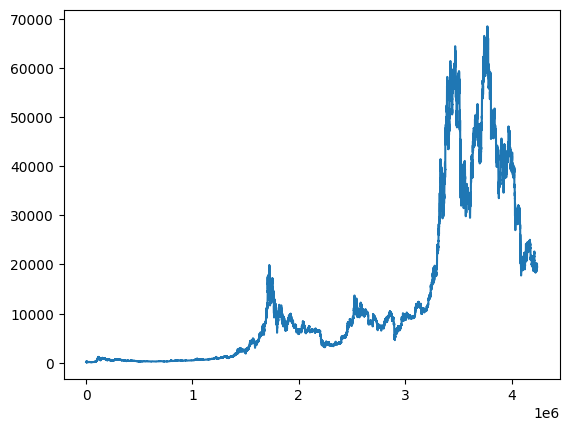

In [5]:
plot_time_series(df, "Close")

/var/folders/q3/l71dn7zj09v3p5_flgkbx0fw0000gn/T/ipykernel_30003/4170282053.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plot_features.index = date_time[:n_smaple]


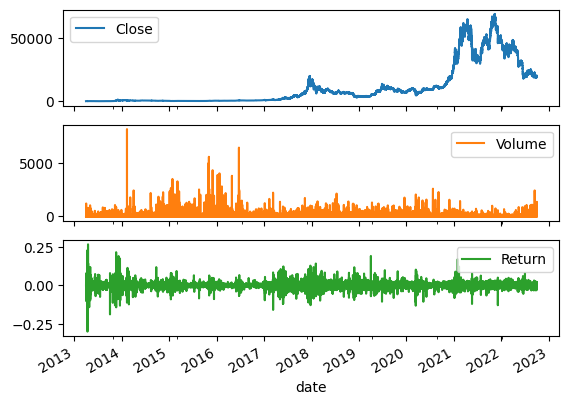

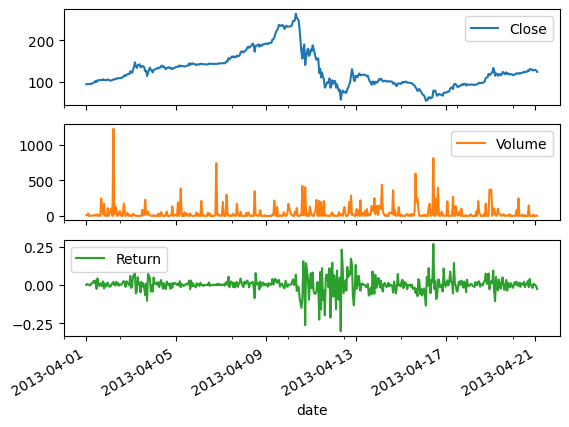

In [6]:
date_time = df["date"]

plot_cols = ['Close', 'Volume', 'Return']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

n_smaple = 480
plot_features = df[plot_cols][:n_smaple]
plot_features.index = date_time[:n_smaple]
_ = plot_features.plot(subplots=True)

## Process Datetime columns

In [7]:
# Ensure column "Open Time" is in type datetime
def process_date(d):
    
    df = d.copy()
    
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["hour"] = df["date"].dt.hour
    df["minute"] = df["date"].dt.minute
    df["dayofweek"] = df["date"].dt.dayofweek

    df = df.set_index(df.date)
    df = df.drop("date", axis=1)
    # df = df.drop("Open Time", axis=1)
    # df = df.drop("Open Time.1", axis=1)
    
    return df


# keep only features for training
def drop_unrequire_col(d, columns: List):
    
    df = d.copy()
    df = df[columns]
    
    return df

In [8]:
columns = ["Volume", "Return",
           "year", "month", "day", "dayofweek", "hour", "minute"]

df = df.pipe(process_date) \
       .pipe(drop_unrequire_col, columns)

print(df.shape)
df.head(5)

(82969, 8)


,Volume,Return,year,month,day,dayofweek,hour,minute
date,,,,,,,,
2013-04-01 00:00:00,12.250,0.000000,2013,4,1,0,0,0
2013-04-01 01:00:00,15.659,0.006817,2013,4,1,0,1,0
2013-04-01 02:00:00,36.750,0.002239,2013,4,1,0,2,0
2013-04-01 03:00:00,0.245,0.000000,2013,4,1,0,3,0
2013-04-01 04:00:00,4.900,-0.004787,2013,4,1,0,4,0


## Building Models

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_else, y_train, y_else = train_test_split(df, df["Return"], test_size=0.2, shuffle=False)
X_valid, X_test, y_valid, y_test = train_test_split(X_else, y_else, test_size=0.5, shuffle=False)

# inspect the shapes
print(X_train.shape, X_valid.shape, X_test.shape)

(66375, 8) (8297, 8) (8297, 8)


In [10]:
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# I literally hate when a standard Scikit function throws big bunches of warnings 
# - though suppressing them is a dangerous practice. Hence this comment. 

def minmax_scale(df_x, series_y, normalizers=None):
    features_to_minmax = ["year", "Volume", "Return"]

    if not normalizers:
        normalizers = {}

    for feat in features_to_minmax:
        if feat not in normalizers:
            normalizers[feat] = MinMaxScaler()
            normalizers[feat].fit(df_x[feat].values.reshape(-1, 1))
        
        df_x[feat] = normalizers[feat].transform(df_x[feat].values.reshape(-1, 1))

    series_y=normalizers["Return"].transform(series_y.values.reshape(-1, 1))

    return df_x, series_y, normalizers

In [11]:
X_train_norm, y_train_norm, normalizers = minmax_scale(X_train, y_train)
X_valid_norm, y_valid_norm, _ = minmax_scale(X_valid, y_valid, normalizers=normalizers)
X_test_norm, y_test_norm, _ = minmax_scale(X_test, y_test, normalizers=normalizers)

In [12]:
X_train_norm

,Volume,Return,year,month,day,dayofweek,hour,minute
date,,,,,,,,
2013-04-01 00:00:00,0.001487,0.530868,0.0,4,1,0,0,0
2013-04-01 01:00:00,0.001901,0.542849,0.0,4,1,0,1,0
2013-04-01 02:00:00,0.004460,0.534803,0.0,4,1,0,2,0
2013-04-01 03:00:00,0.000030,0.530868,0.0,4,1,0,3,0
2013-04-01 04:00:00,0.000595,0.522453,0.0,4,1,0,4,0
...,...,...,...,...,...,...,...,...
2020-11-08 10:00:00,0.001800,0.542132,1.0,11,8,6,10,0
2020-11-08 11:00:00,0.003983,0.540445,1.0,11,8,6,11,0
2020-11-08 12:00:00,0.002339,0.541433,1.0,11,8,6,12,0


## Process cyclical columns such as month and hour

In [13]:
def encode_cyclicals(df_x):
    #"month","day","hour", "dayofweek"

    df_x['month_sin'] = np.sin(2*np.pi*df_x.month/12)
    df_x['month_cos'] = np.cos(2*np.pi*df_x.month/12)
    df_x.drop('month', axis=1, inplace=True)
    
    df_x['day_sin'] = np.sin(2*np.pi*df_x.day/31)
    df_x['day_cos'] = np.cos(2*np.pi*df_x.day/31)
    df_x.drop('day', axis=1, inplace=True)

    df_x['dayofweek_sin'] = np.sin(2*np.pi*df_x.dayofweek/7)
    df_x['dayofweek_cos'] = np.cos(2*np.pi*df_x.dayofweek/7)
    df_x.drop('dayofweek', axis=1, inplace=True)
    
    df_x['hour_sin'] = np.sin(2*np.pi*df_x.hour/24)
    df_x['hour_cos'] = np.cos(2*np.pi*df_x.hour/24)
    df_x.drop('hour', axis=1, inplace=True)
    
    # df_x['minute_sin'] = np.sin(2*np.pi*df_x.minute/60)
    # df_x['minute_cos'] = np.cos(2*np.pi*df_x.minute/60)
    df_x.drop('minute', axis=1, inplace=True)
    
    return df_x

In [14]:
X_train_norm = encode_cyclicals(X_train_norm)
X_valid_norm = encode_cyclicals(X_valid_norm)
X_test_norm = encode_cyclicals(X_test_norm)

In [15]:
X_train_norm

,Volume,Return,year,month_sin,month_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos
date,,,,,,,,,,,
2013-04-01 00:00:00,0.001487,0.530868,0.0,0.866025,-0.500000,0.201299,0.979530,0.000000,1.00000,0.000000e+00,1.000000
2013-04-01 01:00:00,0.001901,0.542849,0.0,0.866025,-0.500000,0.201299,0.979530,0.000000,1.00000,2.588190e-01,0.965926
2013-04-01 02:00:00,0.004460,0.534803,0.0,0.866025,-0.500000,0.201299,0.979530,0.000000,1.00000,5.000000e-01,0.866025
2013-04-01 03:00:00,0.000030,0.530868,0.0,0.866025,-0.500000,0.201299,0.979530,0.000000,1.00000,7.071068e-01,0.707107
2013-04-01 04:00:00,0.000595,0.522453,0.0,0.866025,-0.500000,0.201299,0.979530,0.000000,1.00000,8.660254e-01,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-08 10:00:00,0.001800,0.542132,1.0,-0.500000,0.866025,0.998717,-0.050649,-0.781831,0.62349,5.000000e-01,-0.866025
2020-11-08 11:00:00,0.003983,0.540445,1.0,-0.500000,0.866025,0.998717,-0.050649,-0.781831,0.62349,2.588190e-01,-0.965926
2020-11-08 12:00:00,0.002339,0.541433,1.0,-0.500000,0.866025,0.998717,-0.050649,-0.781831,0.62349,1.224647e-16,-1.000000


In [16]:
TIME_WINDOW=100
FORECAST_DISTANCE=24

In [17]:
y_train_norm

array([[0.53086766],
       [0.54284936],
       [0.53480329],
       ...,
       [0.54143328],
       [0.52394756],
       [0.54346716]])

In [18]:
from seglearn.transform import FeatureRep, SegmentXYForecast, last

segmenter = SegmentXYForecast(width=TIME_WINDOW, step=1, y_func=last, forecast=FORECAST_DISTANCE)

X_train_rolled, y_train_rolled,_=segmenter.fit_transform([X_train_norm.values], [y_train_norm.flatten()])

In [19]:
X_train_rolled[:1]

array([[[ 1.48682425e-03,  5.30867662e-01,  0.00000000e+00, ...,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
        [ 1.90058620e-03,  5.42849360e-01,  0.00000000e+00, ...,
          1.00000000e+00,  2.58819045e-01,  9.65925826e-01],
        [ 4.46047275e-03,  5.34803286e-01,  0.00000000e+00, ...,
          1.00000000e+00,  5.00000000e-01,  8.66025404e-01],
        ...,
        [ 2.33081852e-02,  5.45137012e-01,  0.00000000e+00, ...,
         -9.00968868e-01,  5.00000000e-01,  8.66025404e-01],
        [ 2.08155395e-04,  5.23159925e-01,  0.00000000e+00, ...,
         -9.00968868e-01,  7.07106781e-01,  7.07106781e-01],
        [ 8.35595228e-03,  5.73479242e-01,  0.00000000e+00, ...,
         -9.00968868e-01,  8.66025404e-01,  5.00000000e-01]]])

In [20]:
X_train_rolled.shape

(66252, 100, 11)

In [21]:
shape = X_train_rolled.shape
X_train_flattened = X_train_rolled.reshape(shape[0],shape[1]*shape[2])
X_train_flattened.shape

(66252, 1100)

In [22]:
X_valid_rolled, y_valid_rolled,_=segmenter.fit_transform([X_valid_norm.values],[y_valid_norm.flatten()])

shape = X_valid_rolled.shape
X_valid_flattened = X_valid_rolled.reshape(shape[0],shape[1]*shape[2])

In [23]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def evaluate_model(model, X_valid, y_valid_true):
    predictions = model.predict(X_valid)
    rms = sqrt(mean_squared_error(y_valid_true, predictions))
    print("Root mean squared error on valid:", rms)
    normalized_rms = normalizers["Return"].inverse_transform(np.array([rms]).reshape(1, -1))[0][0]
    print("Root mean squared error on valid inverse transformed from normalization:", normalized_rms)
    return normalized_rms

In [24]:
from sklearn.dummy import DummyRegressor

dummy_model = DummyRegressor(strategy = "median")

dummy_model.fit(X_train_flattened, y_train_rolled)

DummyRegressor(strategy='median')

In [25]:
result = evaluate_model(dummy_model, X_valid_flattened, y_valid_rolled)

Root mean squared error on valid: 0.01725342593800892
Root mean squared error on valid inverse transformed from normalization: -0.29220407602733195


In [26]:
from sklearn.ensemble import RandomForestRegressor

N_ESTIMATORS = 18
RANDOM_STATE = 452543634

In [27]:
warnings.filterwarnings('ignore')

RF_base_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, 
                                      random_state=RANDOM_STATE, 
                                      n_jobs=-1, 
                                      max_depth=30, 
                                      max_features='auto', 
                                      max_leaf_nodes=None, 
                                      bootstrap=True, oob_score=False)

RF_base_model.fit(X_train_flattened, y_train_rolled)

RandomForestRegressor(max_depth=30, max_features='auto', n_estimators=18,
                      n_jobs=-1, random_state=452543634)

In [28]:
result = evaluate_model(RF_base_model, X_valid_flattened, y_valid_rolled)

Root mean squared error on valid: 0.017276568194530082
Root mean squared error on valid inverse transformed from normalization: -0.2921909099949226


In [29]:
warnings.filterwarnings('ignore')

RF_feature_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, 
                                      random_state=RANDOM_STATE, 
                                      n_jobs=-1, 
                                      max_depth=15, 
                                      max_features='auto', 
                                      max_leaf_nodes=None, 
                                      bootstrap=True, oob_score=False)

feature_converter = FeatureRep()

RF_feature_model.fit(feature_converter.fit_transform(X_train_flattened), y_train_rolled)

RandomForestRegressor(max_depth=15, max_features='auto', n_estimators=18,
                      n_jobs=-1, random_state=452543634)

In [30]:
result = evaluate_model(RF_feature_model, feature_converter.fit_transform(X_valid_flattened), y_valid_rolled)

Root mean squared error on valid: 0.019319994381268846
Root mean squared error on valid inverse transformed from normalization: -0.29102836928174175


In [31]:
import xgboost as xgb
# If in trouble, use !pip install xgboost

# XGBoost needs it's custom data format to run quickly
dmatrix_train = xgb.DMatrix(data=X_train_flattened,label=y_train_rolled)
dmatrix_valid = xgb.DMatrix(data=X_valid_flattened,label=y_valid_rolled)

In [32]:
params = {'objective': 'reg:linear', 'eval_metric': 'rmse', 'n_estimators': 28}

evallist = [(dmatrix_valid, 'eval'), (dmatrix_train, 'train')]

num_round = 5 #Can easily overfit, experiment with it!

xg_reg = xgb.train(params, dmatrix_train, num_boost_round=num_round, evals=evallist)

[20:53:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:53:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	eval-rmse:0.02789	train-rmse:0.03117
[1]	eval-rmse:0.02311	train-rmse:0.02693
[2]	eval-rmse:0.02037	train-rmse:0.02452
[3]	eval-rmse:0.01887	train-rmse:0.02323
[4]	eval-rmse:0.01808	train-rmse:0.02254


In [33]:
result = evaluate_model(xg_reg, dmatrix_valid, y_valid_rolled)

Root mean squared error on valid: 0.018080332434170027
Root mean squared error on valid inverse transformed from normalization: -0.29173363453352136


In [34]:
LSTM_CELL_SIZE = 10
BATCH_SIZE = 88
EPOCHS = 12
DROPOUT_RATE = 0.28

In [35]:
warnings.filterwarnings('ignore')

column_count=len(X_train_norm.columns) #Remember,column count before rolling...

be.clear_session()

# You might very well be needing it!
# Remeber to save only what is worth it from validation perspective...
model_saver = ModelCheckpoint(filepath = '/tmp/checkpoint', monitor='val_loss', 
                              verbose=0, 
                              save_best_only=True,save_weights_only=True, 
                              mode='auto', save_freq='epoch', options=None)

# If you need it...
def schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * exp(-0.1)

lr_scheduler = LearningRateScheduler(schedule)

# Build your whole LSTM model here!
model = Sequential()
model.add(LSTM(units = LSTM_CELL_SIZE, input_shape = (TIME_WINDOW, column_count)))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(1, activation = 'linear'))

#For shape remeber, we have a variable defining the "window" and the features in the window...

model.compile(loss='mean_squared_error', optimizer=Adam())
# Fit on the train data
# USE the batch size parameter!
# Use validation data - warning, a tuple of stuff!
# Epochs as deemed necessary...
# You should avoid shuffling the data maybe.
# You can use the callbacks for LR schedule or model saving as seems fit.
history = model.fit(X_train_rolled, y_train_rolled, 
                    batch_size = BATCH_SIZE,
                    validation_data = (X_valid_rolled, y_valid_rolled),
                    epochs = EPOCHS, 
                    verbose = 1, 
                    callbacks =[model_saver, lr_scheduler])

Metal device set to: Apple M1


2022-10-31 20:53:41.958016: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-31 20:53:41.958586: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/12


2022-10-31 20:53:42.275161: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-31 20:53:42.803383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-31 20:53:42.936022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-31 20:53:43.142301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


753/753 [==============================] - ETA: 0s - loss: 0.0660

2022-10-31 20:54:00.429229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-31 20:54:00.475376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


753/753 [==============================] - 20s 25ms/step - loss: 0.0660 - val_loss: 0.0024 - lr: 0.0010
Epoch 2/12
753/753 [==============================] - 18s 24ms/step - loss: 0.0069 - val_loss: 9.6208e-04 - lr: 0.0010
Epoch 3/12
753/753 [==============================] - 18s 24ms/step - loss: 0.0029 - val_loss: 5.9644e-04 - lr: 0.0010
Epoch 4/12
753/753 [==============================] - 18s 24ms/step - loss: 0.0015 - val_loss: 4.0605e-04 - lr: 0.0010
Epoch 5/12
753/753 [==============================] - 18s 24ms/step - loss: 8.9530e-04 - val_loss: 3.4984e-04 - lr: 0.0010
Epoch 6/12
753/753 [==============================] - 18s 24ms/step - loss: 6.3176e-04 - val_loss: 3.1322e-04 - lr: 0.0010
Epoch 7/12
753/753 [==============================] - 18s 24ms/step - loss: 5.4515e-04 - val_loss: 3.0043e-04 - lr: 0.0010
Epoch 8/12
753/753 [==============================] - 18s 24ms/step - loss: 5.1918e-04 - val_loss: 2.9848e-04 - lr: 0.0010
Epoch 9/12
753/753 [===========================

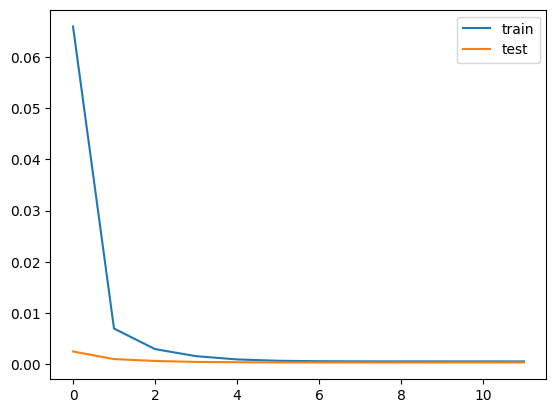

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [37]:
warnings.filterwarnings('ignore')

result = evaluate_model(model, X_valid_rolled, y_valid_rolled)

  1/256 [..............................] - ETA: 1:07

2022-10-31 20:57:23.176391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-31 20:57:23.217307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


256/256 [==============================] - 3s 12ms/step
Root mean squared error on valid: 0.017405355369747362
Root mean squared error on valid inverse transformed from normalization: -0.29211764073004903
